In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Wed Jul  8 11:33:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 41%   57C    P2    41W / 250W |   3403MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Imports

In [3]:
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

import mlflow

from model.collectdata_mdsA import collect_data
from model.alt_loss_A import Loss
from model.training import trainNet, select_gpu
from model.models_mds_07July2020 import SimpleCNN5Layer_Ca as Model
from model.training import trainNet, select_gpu, Results
from model.utilities import load_full_state, count_parameters
from model.plots import dual_train_plots, replace_in_ax
from model.utilities import count_parameters, Params
import hiddenlayer as HL
from torchsummary import summary

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [6]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 200, 1e-3, 0)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [5]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Aug14_80K_train.h5',
                            '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Aug14_80K_train.h5 in 10.8 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 10.73 s
Constructing 160000 event dataset took 4.136 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.755 s
Constructing 9984 event dataset took 0.06994 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [8]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


ct, child =  0    Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  1    Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  2    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  3    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  4    Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  5    Dropout(p=0.15, inplace=False)
ct, child =  6    Dropout(p=0.15, inplace=False)
ct, child =  7    Dropout(p=0.15, inplace=False)
ct, child =  8    Dropout(p=0.15, inplace=False)
ct, child =  9    Dropout(p=0.35, inplace=False)
ct, child =  10    Linear(in_features=4000, out_features=4000, bias=True)


In [9]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [11]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

path = 'run_stats.pyt'
load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = torch.load('/share/lazy/sokoloff/ML/02June2020_CNN5Layer_Ca_yetAnother200epochs_K/02June2020_CNN5Layer_Ca_yetAnother200epochs_K_final.pyt')
load_full_state(model, optimizer, pretrained_dict)

In [ ]:
model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


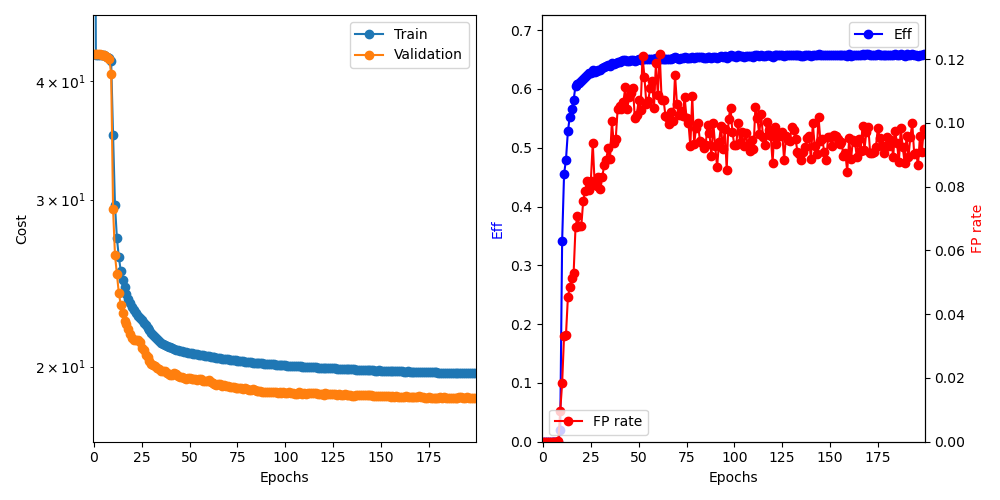

for model:  SimpleCNN5Layer_Ca(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=4000, out_features=4000, bias=True)
)
epoch_start 0
batch_size 128
epochs 200
lr 9e-05
Number of batches: train = 1250, val = 78


/home/michael24peters/pv-finder/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 0: train=207.022, val=42.7002, took 23.763 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 1: train=42.6523, val=42.6983, took 23.559 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 2: train=42.6488, val=42.6923, took 23.057 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 3: train=42.6418, val=42.6824, took 23.112 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 4: train=42.6262, val=42.6533, took 23.122 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 5: train=42.5819, val=42.5937, took 23.291 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 6: train=42.5195, val=42.5083, took 23.061 s
  Validation Found 0 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 7: train=42.4088, val=42.3772, took 23.451 s
  Validation Found 1 of 54504, added 0 (eff 0.00%) (0.0 FP/event)


Epoch 8: train=42.2858, val=42.2309, took 23.415 s
  Validation Found 5 of 54504, added 2 (eff 0.01%) (0.0002 FP/event)


Epoch 9: train=41.9575, val=40.7315, took 23.457 s
  Validation Found 1130 of 54504, added 97 (eff 2.07%) (0.00971 FP/event)


Epoch 10: train=35.059, val=29.2975, took 23.35 s
  Validation Found 18644 of 54504, added 184 (eff 34.21%) (0.0184 FP/event)


Epoch 11: train=29.608, val=26.2109, took 23.694 s
  Validation Found 24793 of 54504, added 332 (eff 45.49%) (0.0332 FP/event)


Epoch 12: train=27.3237, val=25.0461, took 23.332 s
  Validation Found 26161 of 54504, added 335 (eff 48.00%) (0.0336 FP/event)


Epoch 13: train=26.1017, val=23.9085, took 22.929 s
  Validation Found 28762 of 54504, added 452 (eff 52.77%) (0.0453 FP/event)


Epoch 14: train=25.2466, val=23.2463, took 23.416 s
  Validation Found 30141 of 54504, added 484 (eff 55.30%) (0.0485 FP/event)


Epoch 15: train=24.691, val=22.763, took 23.128 s
  Validation Found 30873 of 54504, added 513 (eff 56.64%) (0.0514 FP/event)


Epoch 16: train=24.2522, val=22.3543, took 23.012 s
  Validation Found 31711 of 54504, added 529 (eff 58.18%) (0.053 FP/event)


Epoch 17: train=23.8727, val=22.2051, took 23.036 s
  Validation Found 32987 of 54504, added 673 (eff 60.52%) (0.0674 FP/event)


Epoch 18: train=23.5656, val=21.9024, took 23.675 s
  Validation Found 33202 of 54504, added 706 (eff 60.92%) (0.0707 FP/event)


Epoch 19: train=23.3165, val=21.6433, took 23.275 s
  Validation Found 33277 of 54504, added 675 (eff 61.05%) (0.0676 FP/event)


Epoch 20: train=23.1079, val=21.4168, took 23.019 s
  Validation Found 33439 of 54504, added 675 (eff 61.35%) (0.0676 FP/event)


Epoch 21: train=22.9364, val=21.316, took 23.206 s
  Validation Found 33663 of 54504, added 754 (eff 61.76%) (0.0755 FP/event)


Epoch 22: train=22.7849, val=21.334, took 23.279 s
  Validation Found 33851 of 54504, added 784 (eff 62.11%) (0.0785 FP/event)


Epoch 23: train=22.6377, val=21.3437, took 23.431 s
  Validation Found 34027 of 54504, added 817 (eff 62.43%) (0.0818 FP/event)


Epoch 24: train=22.5175, val=21.225, took 23.329 s
  Validation Found 34160 of 54504, added 788 (eff 62.67%) (0.0789 FP/event)


Epoch 25: train=22.3862, val=20.9234, took 23.37 s
  Validation Found 34208 of 54504, added 818 (eff 62.76%) (0.0819 FP/event)


Epoch 26: train=22.2374, val=20.8035, took 23.271 s
  Validation Found 34437 of 54504, added 936 (eff 63.18%) (0.0937 FP/event)


Epoch 27: train=22.112, val=20.5563, took 22.978 s
  Validation Found 34286 of 54504, added 806 (eff 62.91%) (0.0807 FP/event)


Epoch 28: train=21.9903, val=20.4578, took 23.27 s
  Validation Found 34415 of 54504, added 800 (eff 63.14%) (0.0801 FP/event)


Epoch 29: train=21.8592, val=20.2861, took 23.154 s
  Validation Found 34486 of 54504, added 828 (eff 63.27%) (0.0829 FP/event)


Epoch 30: train=21.7146, val=20.1464, took 23.374 s
  Validation Found 34467 of 54504, added 791 (eff 63.24%) (0.0792 FP/event)


Epoch 31: train=21.5913, val=20.0907, took 23.264 s
  Validation Found 34655 of 54504, added 830 (eff 63.58%) (0.0831 FP/event)


Epoch 32: train=21.4814, val=20.0108, took 23.235 s
  Validation Found 34762 of 54504, added 868 (eff 63.78%) (0.0869 FP/event)


Epoch 33: train=21.3782, val=19.9166, took 22.993 s
  Validation Found 34814 of 54504, added 882 (eff 63.87%) (0.0883 FP/event)


Epoch 34: train=21.2891, val=19.879, took 23.36 s
  Validation Found 34934 of 54504, added 919 (eff 64.09%) (0.092 FP/event)


Epoch 35: train=21.2057, val=19.8115, took 23.366 s
  Validation Found 34858 of 54504, added 885 (eff 63.95%) (0.0886 FP/event)


Epoch 36: train=21.1399, val=19.8093, took 23.6 s
  Validation Found 35097 of 54504, added 1003 (eff 64.39%) (0.1 FP/event)


Epoch 37: train=21.0878, val=19.7781, took 23.285 s
  Validation Found 35050 of 54504, added 935 (eff 64.31%) (0.0936 FP/event)


Epoch 38: train=21.0385, val=19.7099, took 23.343 s
  Validation Found 35096 of 54504, added 948 (eff 64.39%) (0.0949 FP/event)


Epoch 39: train=20.9899, val=19.6325, took 22.999 s
  Validation Found 35165 of 54504, added 1042 (eff 64.52%) (0.104 FP/event)


Epoch 40: train=20.951, val=19.5861, took 23.427 s
  Validation Found 35214 of 54504, added 1053 (eff 64.61%) (0.105 FP/event)


Epoch 41: train=20.9062, val=19.5958, took 23.378 s
  Validation Found 35277 of 54504, added 1042 (eff 64.72%) (0.104 FP/event)


Epoch 42: train=20.8842, val=19.6776, took 23.162 s
  Validation Found 35347 of 54504, added 1063 (eff 64.85%) (0.106 FP/event)


Epoch 43: train=20.8389, val=19.6376, took 23.314 s
  Validation Found 35400 of 54504, added 1111 (eff 64.95%) (0.111 FP/event)


Epoch 44: train=20.8208, val=19.5519, took 23.299 s
  Validation Found 35335 of 54504, added 1042 (eff 64.83%) (0.104 FP/event)


Epoch 45: train=20.7896, val=19.4864, took 23.291 s
  Validation Found 35335 of 54504, added 1079 (eff 64.83%) (0.108 FP/event)


Epoch 46: train=20.7675, val=19.5256, took 23.373 s
  Validation Found 35405 of 54504, added 1092 (eff 64.96%) (0.109 FP/event)


Epoch 47: train=20.7395, val=19.4768, took 23.234 s
  Validation Found 35425 of 54504, added 1108 (eff 65.00%) (0.111 FP/event)


Epoch 48: train=20.724, val=19.4036, took 23.505 s
  Validation Found 35284 of 54504, added 1013 (eff 64.74%) (0.101 FP/event)


Epoch 49: train=20.693, val=19.4533, took 23.211 s
  Validation Found 35378 of 54504, added 1024 (eff 64.91%) (0.103 FP/event)


Epoch 50: train=20.6813, val=19.4338, took 23.152 s
  Validation Found 35447 of 54504, added 1070 (eff 65.04%) (0.107 FP/event)


Epoch 51: train=20.6583, val=19.4235, took 23.265 s
  Validation Found 35385 of 54504, added 1039 (eff 64.92%) (0.104 FP/event)


Epoch 52: train=20.6352, val=19.4158, took 23.306 s
  Validation Found 35529 of 54504, added 1208 (eff 65.19%) (0.121 FP/event)


Epoch 53: train=20.6149, val=19.3952, took 23.265 s
  Validation Found 35513 of 54504, added 1143 (eff 65.16%) (0.114 FP/event)


Epoch 54: train=20.6025, val=19.3657, took 23.288 s
  Validation Found 35437 of 54504, added 1059 (eff 65.02%) (0.106 FP/event)


Epoch 55: train=20.5835, val=19.3866, took 23.386 s
  Validation Found 35492 of 54504, added 1067 (eff 65.12%) (0.107 FP/event)


Epoch 56: train=20.5732, val=19.3912, took 23.209 s
  Validation Found 35518 of 54504, added 1109 (eff 65.17%) (0.111 FP/event)


Epoch 57: train=20.5539, val=19.3171, took 23.251 s
  Validation Found 35527 of 54504, added 1129 (eff 65.18%) (0.113 FP/event)


Epoch 58: train=20.5384, val=19.3189, took 23.176 s
  Validation Found 35472 of 54504, added 1046 (eff 65.08%) (0.105 FP/event)


Epoch 59: train=20.5249, val=19.3195, took 23.273 s
  Validation Found 35613 of 54504, added 1185 (eff 65.34%) (0.119 FP/event)


Epoch 60: train=20.5081, val=19.3466, took 23.103 s
  Validation Found 35548 of 54504, added 1086 (eff 65.22%) (0.109 FP/event)


Epoch 61: train=20.4863, val=19.2828, took 22.987 s
  Validation Found 35638 of 54504, added 1215 (eff 65.39%) (0.122 FP/event)


Epoch 62: train=20.4768, val=19.2065, took 23.291 s
  Validation Found 35503 of 54504, added 1070 (eff 65.14%) (0.107 FP/event)


Epoch 63: train=20.4528, val=19.1752, took 23.361 s
  Validation Found 35503 of 54504, added 1070 (eff 65.14%) (0.107 FP/event)


Epoch 64: train=20.4419, val=19.1372, took 23.281 s
  Validation Found 35471 of 54504, added 1021 (eff 65.08%) (0.102 FP/event)


Epoch 65: train=20.4279, val=19.1569, took 23.303 s
  Validation Found 35471 of 54504, added 1017 (eff 65.08%) (0.102 FP/event)


Epoch 66: train=20.4119, val=19.155, took 23.267 s
  Validation Found 35476 of 54504, added 994 (eff 65.09%) (0.0995 FP/event)


Epoch 67: train=20.3949, val=19.0976, took 23.598 s
  Validation Found 35527 of 54504, added 1033 (eff 65.18%) (0.103 FP/event)


Epoch 68: train=20.3847, val=19.1248, took 23.432 s
  Validation Found 35533 of 54504, added 1006 (eff 65.19%) (0.101 FP/event)


Epoch 69: train=20.3794, val=19.0867, took 23.219 s
  Validation Found 35654 of 54504, added 1150 (eff 65.42%) (0.115 FP/event)


Epoch 70: train=20.3555, val=19.0855, took 23.13 s
  Validation Found 35612 of 54504, added 1058 (eff 65.34%) (0.106 FP/event)


Epoch 71: train=20.3406, val=19.0153, took 23.248 s
  Validation Found 35510 of 54504, added 1022 (eff 65.15%) (0.102 FP/event)


Epoch 72: train=20.3261, val=19.0325, took 24.017 s
  Validation Found 35588 of 54504, added 1036 (eff 65.29%) (0.104 FP/event)


Epoch 73: train=20.3099, val=19.0335, took 23.542 s
  Validation Found 35592 of 54504, added 1019 (eff 65.30%) (0.102 FP/event)


Epoch 74: train=20.3084, val=19.0, took 23.259 s
  Validation Found 35636 of 54504, added 1081 (eff 65.38%) (0.108 FP/event)


Epoch 75: train=20.2947, val=19.0011, took 23.249 s
  Validation Found 35596 of 54504, added 1015 (eff 65.31%) (0.102 FP/event)


Epoch 76: train=20.2875, val=18.9868, took 23.449 s
  Validation Found 35609 of 54504, added 999 (eff 65.33%) (0.1 FP/event)


Epoch 77: train=20.2704, val=18.9874, took 23.069 s
  Validation Found 35534 of 54504, added 926 (eff 65.20%) (0.0927 FP/event)


Epoch 78: train=20.2595, val=18.9466, took 23.428 s
  Validation Found 35685 of 54504, added 1082 (eff 65.47%) (0.108 FP/event)


Epoch 79: train=20.2485, val=18.9707, took 23.486 s
  Validation Found 35581 of 54504, added 933 (eff 65.28%) (0.0934 FP/event)


Epoch 80: train=20.2319, val=18.9536, took 23.415 s
  Validation Found 35630 of 54504, added 983 (eff 65.37%) (0.0984 FP/event)


Epoch 81: train=20.2212, val=18.8942, took 23.223 s
  Validation Found 35630 of 54504, added 999 (eff 65.37%) (0.1 FP/event)


Epoch 82: train=20.2164, val=18.9161, took 23.268 s
  Validation Found 35633 of 54504, added 942 (eff 65.38%) (0.0943 FP/event)


Epoch 83: train=20.1937, val=18.9399, took 23.325 s
  Validation Found 35625 of 54504, added 936 (eff 65.36%) (0.0937 FP/event)


Epoch 84: train=20.1953, val=18.8788, took 23.125 s
  Validation Found 35590 of 54504, added 919 (eff 65.30%) (0.092 FP/event)


Epoch 85: train=20.178, val=18.8328, took 23.192 s
  Validation Found 35600 of 54504, added 929 (eff 65.32%) (0.093 FP/event)


Epoch 86: train=20.1719, val=18.8594, took 23.088 s
  Validation Found 35685 of 54504, added 992 (eff 65.47%) (0.0993 FP/event)


Epoch 87: train=20.1607, val=18.8361, took 23.322 s
  Validation Found 35651 of 54504, added 966 (eff 65.41%) (0.0967 FP/event)


Epoch 88: train=20.1593, val=18.8201, took 23.845 s
  Validation Found 35583 of 54504, added 894 (eff 65.29%) (0.0895 FP/event)


Epoch 89: train=20.1465, val=18.8011, took 23.48 s
  Validation Found 35696 of 54504, added 998 (eff 65.49%) (0.0999 FP/event)


Epoch 90: train=20.1361, val=18.807, took 23.396 s
  Validation Found 35669 of 54504, added 925 (eff 65.44%) (0.0926 FP/event)


Epoch 91: train=20.1268, val=18.8176, took 23.29 s
  Validation Found 35585 of 54504, added 861 (eff 65.29%) (0.0862 FP/event)


Epoch 92: train=20.1236, val=18.808, took 23.375 s
  Validation Found 35681 of 54504, added 938 (eff 65.46%) (0.0939 FP/event)


Epoch 93: train=20.1097, val=18.7833, took 23.46 s
  Validation Found 35721 of 54504, added 989 (eff 65.54%) (0.099 FP/event)


Epoch 94: train=20.1043, val=18.7871, took 23.239 s
  Validation Found 35672 of 54504, added 917 (eff 65.45%) (0.0918 FP/event)


Epoch 95: train=20.0968, val=18.7985, took 23.491 s
  Validation Found 35726 of 54504, added 979 (eff 65.55%) (0.098 FP/event)


Epoch 96: train=20.0894, val=18.75, took 23.236 s
  Validation Found 35565 of 54504, added 851 (eff 65.25%) (0.0852 FP/event)


Epoch 97: train=20.0818, val=18.7955, took 23.291 s
  Validation Found 35798 of 54504, added 1012 (eff 65.68%) (0.101 FP/event)


Epoch 98: train=20.0749, val=18.7725, took 23.246 s
  Validation Found 35834 of 54504, added 1045 (eff 65.75%) (0.105 FP/event)


Epoch 99: train=20.0668, val=18.7869, took 23.236 s
  Validation Found 35777 of 54504, added 970 (eff 65.64%) (0.0971 FP/event)


Epoch 100: train=20.057, val=18.7729, took 23.101 s
  Validation Found 35737 of 54504, added 928 (eff 65.57%) (0.0929 FP/event)


Epoch 101: train=20.0503, val=18.7541, took 23.164 s
  Validation Found 35697 of 54504, added 929 (eff 65.49%) (0.093 FP/event)


Epoch 102: train=20.0412, val=18.7895, took 23.535 s
  Validation Found 35813 of 54504, added 998 (eff 65.71%) (0.0999 FP/event)


Epoch 103: train=20.0394, val=18.7817, took 23.479 s
  Validation Found 35739 of 54504, added 936 (eff 65.57%) (0.0937 FP/event)


Epoch 104: train=20.0361, val=18.7585, took 23.621 s
  Validation Found 35780 of 54504, added 971 (eff 65.65%) (0.0972 FP/event)


Epoch 105: train=20.0304, val=18.7187, took 23.191 s
  Validation Found 35671 of 54504, added 926 (eff 65.45%) (0.0927 FP/event)


Epoch 106: train=20.0212, val=18.7318, took 23.374 s
  Validation Found 35749 of 54504, added 967 (eff 65.59%) (0.0968 FP/event)


Epoch 107: train=20.02, val=18.7907, took 23.191 s
  Validation Found 35771 of 54504, added 928 (eff 65.63%) (0.0929 FP/event)


Epoch 108: train=20.0108, val=18.7774, took 23.2 s
  Validation Found 35716 of 54504, added 910 (eff 65.53%) (0.0911 FP/event)


Epoch 109: train=20.0015, val=18.7204, took 23.275 s
  Validation Found 35762 of 54504, added 944 (eff 65.61%) (0.0945 FP/event)


Epoch 110: train=19.9898, val=18.7384, took 23.06 s
  Validation Found 35705 of 54504, added 916 (eff 65.51%) (0.0917 FP/event)


Epoch 111: train=19.9935, val=18.7166, took 23.228 s
  Validation Found 35867 of 54504, added 1047 (eff 65.81%) (0.105 FP/event)


Epoch 112: train=19.9783, val=18.7736, took 23.375 s
  Validation Found 35817 of 54504, added 1015 (eff 65.71%) (0.102 FP/event)


Epoch 113: train=19.9801, val=18.7529, took 23.163 s
  Validation Found 35779 of 54504, added 963 (eff 65.64%) (0.0964 FP/event)


Epoch 114: train=19.9772, val=18.7571, took 23.574 s
  Validation Found 35862 of 54504, added 1026 (eff 65.80%) (0.103 FP/event)


Epoch 115: train=19.9636, val=18.7426, took 23.201 s
  Validation Found 35780 of 54504, added 953 (eff 65.65%) (0.0954 FP/event)


Epoch 116: train=19.9595, val=18.7411, took 22.992 s
  Validation Found 35769 of 54504, added 930 (eff 65.63%) (0.0931 FP/event)


Epoch 117: train=19.9565, val=18.6969, took 23.29 s
  Validation Found 35821 of 54504, added 1002 (eff 65.72%) (0.1 FP/event)


Epoch 118: train=19.9553, val=18.7203, took 23.155 s
  Validation Found 35813 of 54504, added 975 (eff 65.71%) (0.0976 FP/event)


Epoch 119: train=19.9425, val=18.7177, took 23.273 s
  Validation Found 35790 of 54504, added 957 (eff 65.66%) (0.0958 FP/event)


Epoch 120: train=19.9419, val=18.6789, took 23.354 s
  Validation Found 35684 of 54504, added 874 (eff 65.47%) (0.0875 FP/event)


Epoch 121: train=19.9362, val=18.7382, took 23.31 s
  Validation Found 35866 of 54504, added 986 (eff 65.80%) (0.0987 FP/event)


Epoch 122: train=19.9293, val=18.7142, took 23.385 s
  Validation Found 35809 of 54504, added 931 (eff 65.70%) (0.0932 FP/event)


Epoch 123: train=19.9267, val=18.7291, took 23.334 s
  Validation Found 35853 of 54504, added 963 (eff 65.78%) (0.0964 FP/event)


Epoch 124: train=19.9273, val=18.7269, took 23.466 s
  Validation Found 35834 of 54504, added 956 (eff 65.75%) (0.0957 FP/event)


Epoch 125: train=19.9203, val=18.7018, took 23.261 s
  Validation Found 35845 of 54504, added 969 (eff 65.77%) (0.097 FP/event)


Epoch 126: train=19.9139, val=18.705, took 23.37 s
  Validation Found 35745 of 54504, added 883 (eff 65.58%) (0.0884 FP/event)


Epoch 127: train=19.9073, val=18.6718, took 23.245 s
  Validation Found 35846 of 54504, added 956 (eff 65.77%) (0.0957 FP/event)


Epoch 128: train=19.9075, val=18.7225, took 23.319 s
  Validation Found 35867 of 54504, added 944 (eff 65.81%) (0.0945 FP/event)


Epoch 129: train=19.8989, val=18.6815, took 23.174 s
  Validation Found 35813 of 54504, added 942 (eff 65.71%) (0.0943 FP/event)


Epoch 130: train=19.8894, val=18.6625, took 23.365 s
  Validation Found 35890 of 54504, added 986 (eff 65.85%) (0.0987 FP/event)


Epoch 131: train=19.8862, val=18.7061, took 23.336 s
  Validation Found 35889 of 54504, added 975 (eff 65.85%) (0.0976 FP/event)


Epoch 132: train=19.8822, val=18.6604, took 23.296 s
  Validation Found 35845 of 54504, added 948 (eff 65.77%) (0.0949 FP/event)


Epoch 133: train=19.873, val=18.6805, took 23.522 s
  Validation Found 35814 of 54504, added 907 (eff 65.71%) (0.0908 FP/event)


Epoch 134: train=19.8829, val=18.6803, took 23.294 s
  Validation Found 35828 of 54504, added 902 (eff 65.73%) (0.0903 FP/event)


Epoch 135: train=19.8731, val=18.6435, took 23.371 s
  Validation Found 35755 of 54504, added 883 (eff 65.60%) (0.0884 FP/event)


Epoch 136: train=19.8636, val=18.6322, took 23.237 s
  Validation Found 35804 of 54504, added 906 (eff 65.69%) (0.0907 FP/event)


Epoch 137: train=19.8581, val=18.6584, took 23.954 s
  Validation Found 35817 of 54504, added 923 (eff 65.71%) (0.0924 FP/event)


Epoch 138: train=19.8594, val=18.6598, took 23.25 s
  Validation Found 35865 of 54504, added 952 (eff 65.80%) (0.0953 FP/event)


Epoch 139: train=19.8515, val=18.6735, took 23.15 s
  Validation Found 35852 of 54504, added 958 (eff 65.78%) (0.0959 FP/event)


Epoch 140: train=19.8465, val=18.6555, took 23.52 s
  Validation Found 35790 of 54504, added 884 (eff 65.66%) (0.0885 FP/event)


Epoch 141: train=19.8426, val=18.647, took 23.224 s
  Validation Found 35890 of 54504, added 998 (eff 65.85%) (0.0999 FP/event)


Epoch 142: train=19.835, val=18.6544, took 23.449 s
  Validation Found 35845 of 54504, added 925 (eff 65.77%) (0.0926 FP/event)


Epoch 143: train=19.8435, val=18.6498, took 23.273 s
  Validation Found 35832 of 54504, added 902 (eff 65.74%) (0.0903 FP/event)


Epoch 144: train=19.8273, val=18.6834, took 23.278 s
  Validation Found 35964 of 54504, added 1017 (eff 65.98%) (0.102 FP/event)


Epoch 145: train=19.8266, val=18.6731, took 23.318 s
  Validation Found 35871 of 54504, added 941 (eff 65.81%) (0.0942 FP/event)


Epoch 146: train=19.8265, val=18.6414, took 23.316 s
  Validation Found 35861 of 54504, added 947 (eff 65.80%) (0.0948 FP/event)


Epoch 147: train=19.8121, val=18.6167, took 23.268 s
  Validation Found 35829 of 54504, added 906 (eff 65.74%) (0.0907 FP/event)


Epoch 148: train=19.812, val=18.6228, took 23.224 s
  Validation Found 35811 of 54504, added 882 (eff 65.70%) (0.0883 FP/event)


Epoch 149: train=19.8147, val=18.6254, took 23.329 s
  Validation Found 35851 of 54504, added 953 (eff 65.78%) (0.0954 FP/event)


Epoch 150: train=19.8087, val=18.6199, took 23.144 s
  Validation Found 35884 of 54504, added 955 (eff 65.84%) (0.0956 FP/event)


Epoch 151: train=19.8048, val=18.61, took 23.613 s
  Validation Found 35857 of 54504, added 925 (eff 65.79%) (0.0926 FP/event)


Epoch 152: train=19.7938, val=18.6386, took 23.182 s
  Validation Found 35890 of 54504, added 960 (eff 65.85%) (0.0961 FP/event)


Epoch 153: train=19.7939, val=18.6167, took 23.089 s
  Validation Found 35865 of 54504, added 957 (eff 65.80%) (0.0958 FP/event)


Epoch 154: train=19.7892, val=18.6139, took 23.486 s
  Validation Found 35864 of 54504, added 947 (eff 65.80%) (0.0948 FP/event)


Epoch 155: train=19.7941, val=18.5879, took 23.295 s
  Validation Found 35866 of 54504, added 931 (eff 65.80%) (0.0932 FP/event)


Epoch 156: train=19.7855, val=18.6048, took 23.546 s
  Validation Found 35853 of 54504, added 940 (eff 65.78%) (0.0941 FP/event)


Epoch 157: train=19.7787, val=18.5927, took 23.304 s
  Validation Found 35816 of 54504, added 896 (eff 65.71%) (0.0897 FP/event)


Epoch 158: train=19.7741, val=18.6035, took 23.363 s
  Validation Found 35821 of 54504, added 904 (eff 65.72%) (0.0905 FP/event)


Epoch 159: train=19.7736, val=18.5898, took 23.226 s
  Validation Found 35760 of 54504, added 846 (eff 65.61%) (0.0847 FP/event)


Epoch 160: train=19.7766, val=18.5856, took 23.527 s
  Validation Found 35928 of 54504, added 950 (eff 65.92%) (0.0951 FP/event)


Epoch 161: train=19.7699, val=18.5807, took 23.058 s
  Validation Found 35795 of 54504, added 886 (eff 65.67%) (0.0887 FP/event)


Epoch 162: train=19.7639, val=18.5892, took 23.193 s
  Validation Found 35871 of 54504, added 946 (eff 65.81%) (0.0947 FP/event)


Epoch 163: train=19.764, val=18.6008, took 23.427 s
  Validation Found 35889 of 54504, added 939 (eff 65.85%) (0.094 FP/event)


Epoch 164: train=19.7672, val=18.5721, took 23.195 s
  Validation Found 35860 of 54504, added 892 (eff 65.79%) (0.0893 FP/event)


Epoch 165: train=19.7582, val=18.5737, took 23.327 s
  Validation Found 35873 of 54504, added 948 (eff 65.82%) (0.0949 FP/event)


Epoch 166: train=19.7615, val=18.5886, took 23.201 s
  Validation Found 35821 of 54504, added 910 (eff 65.72%) (0.0911 FP/event)


Epoch 167: train=19.7558, val=18.5748, took 23.594 s
  Validation Found 35907 of 54504, added 990 (eff 65.88%) (0.0991 FP/event)


Epoch 168: train=19.7509, val=18.578, took 23.242 s
  Validation Found 35850 of 54504, added 915 (eff 65.77%) (0.0916 FP/event)


Epoch 169: train=19.7489, val=18.5813, took 23.213 s
  Validation Found 35914 of 54504, added 970 (eff 65.89%) (0.0971 FP/event)


Epoch 170: train=19.7443, val=18.6016, took 23.081 s
  Validation Found 35929 of 54504, added 986 (eff 65.92%) (0.0987 FP/event)


Epoch 171: train=19.7427, val=18.5941, took 23.508 s
  Validation Found 35845 of 54504, added 904 (eff 65.77%) (0.0905 FP/event)


Epoch 172: train=19.736, val=18.5641, took 23.478 s
  Validation Found 35819 of 54504, added 903 (eff 65.72%) (0.0904 FP/event)


Epoch 173: train=19.7426, val=18.55, took 23.204 s
  Validation Found 35844 of 54504, added 906 (eff 65.76%) (0.0907 FP/event)


Epoch 174: train=19.7305, val=18.5532, took 23.086 s
  Validation Found 35855 of 54504, added 924 (eff 65.78%) (0.0925 FP/event)


Epoch 175: train=19.7299, val=18.5825, took 23.344 s
  Validation Found 35908 of 54504, added 983 (eff 65.88%) (0.0984 FP/event)


Epoch 176: train=19.7295, val=18.5493, took 23.555 s
  Validation Found 35863 of 54504, added 950 (eff 65.80%) (0.0951 FP/event)


Epoch 177: train=19.7234, val=18.5512, took 23.267 s
  Validation Found 35846 of 54504, added 926 (eff 65.77%) (0.0927 FP/event)


Epoch 178: train=19.7281, val=18.5409, took 23.387 s
  Validation Found 35843 of 54504, added 904 (eff 65.76%) (0.0905 FP/event)


Epoch 179: train=19.7204, val=18.5418, took 23.026 s
  Validation Found 35839 of 54504, added 926 (eff 65.75%) (0.0927 FP/event)


Epoch 180: train=19.7098, val=18.5411, took 23.259 s
  Validation Found 35888 of 54504, added 954 (eff 65.84%) (0.0955 FP/event)


Epoch 181: train=19.7126, val=18.5804, took 23.199 s
  Validation Found 35874 of 54504, added 926 (eff 65.82%) (0.0927 FP/event)


Epoch 182: train=19.7163, val=18.5516, took 23.305 s
  Validation Found 35886 of 54504, added 945 (eff 65.84%) (0.0946 FP/event)


Epoch 183: train=19.7072, val=18.5642, took 23.173 s
  Validation Found 35827 of 54504, added 891 (eff 65.73%) (0.0892 FP/event)


Epoch 184: train=19.7128, val=18.5459, took 23.397 s
  Validation Found 35940 of 54504, added 974 (eff 65.94%) (0.0975 FP/event)


Epoch 185: train=19.7023, val=18.5382, took 23.3 s
  Validation Found 35863 of 54504, added 936 (eff 65.80%) (0.0937 FP/event)


Epoch 186: train=19.7023, val=18.5223, took 23.652 s
  Validation Found 35812 of 54504, added 876 (eff 65.71%) (0.0877 FP/event)


Epoch 187: train=19.7031, val=18.536, took 23.261 s
  Validation Found 35926 of 54504, added 983 (eff 65.91%) (0.0984 FP/event)


Epoch 188: train=19.6948, val=18.5456, took 23.096 s
  Validation Found 35869 of 54504, added 923 (eff 65.81%) (0.0924 FP/event)


Epoch 189: train=19.6991, val=18.5374, took 23.04 s
  Validation Found 35799 of 54504, added 873 (eff 65.68%) (0.0874 FP/event)


Epoch 190: train=19.6906, val=18.554, took 23.209 s
  Validation Found 35916 of 54504, added 957 (eff 65.90%) (0.0958 FP/event)


Epoch 191: train=19.6927, val=18.5689, took 23.24 s
  Validation Found 35834 of 54504, added 892 (eff 65.75%) (0.0893 FP/event)


Epoch 192: train=19.6884, val=18.5581, took 23.326 s
  Validation Found 35898 of 54504, added 955 (eff 65.86%) (0.0956 FP/event)


Epoch 193: train=19.6887, val=18.548, took 23.449 s
  Validation Found 35954 of 54504, added 997 (eff 65.97%) (0.0998 FP/event)


Epoch 194: train=19.6912, val=18.5317, took 23.2 s
  Validation Found 35840 of 54504, added 901 (eff 65.76%) (0.0902 FP/event)


Epoch 195: train=19.6844, val=18.5764, took 23.335 s
  Validation Found 35865 of 54504, added 905 (eff 65.80%) (0.0906 FP/event)


Epoch 196: train=19.6778, val=18.5382, took 23.326 s
  Validation Found 35781 of 54504, added 866 (eff 65.65%) (0.0867 FP/event)


Epoch 197: train=19.6737, val=18.5251, took 23.338 s
  Validation Found 35893 of 54504, added 957 (eff 65.85%) (0.0958 FP/event)


Epoch 198: train=19.6823, val=18.5178, took 23.402 s
  Validation Found 35834 of 54504, added 907 (eff 65.75%) (0.0908 FP/event)


Epoch 199: train=19.6743, val=18.5398, took 23.317 s
  Validation Found 35924 of 54504, added 980 (eff 65.91%) (0.0981 FP/event)



In [12]:
print('for model: ', model)   
run_name = 'SCNN-ACNN freeze'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
        plt.tight_layout()
        fig.savefig('plot.png')
            
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
        HL.transforms.Fold("Conv", "Conv"),
        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
        # save plot
        mlflow.log_artifact('plot.png')

In [16]:
##quit()